In [ ]:
library(tidyverse)
library(nowcastDFM)

In [2]:
# helper function, generate lagged datasets for testing on vintages
gen_lagged_data <- function (metadata, data, last_date, lag) {
  # only go up to the last date
  lagged_data <- data %>% 
    dplyr::filter(date <= last_date)
  
  for (col in colnames(lagged_data)[2:length(colnames(lagged_data))]) {
    pub_lag <- metadata %>% 
      dplyr::filter(series == col) %>% 
      select(months_lag) %>% 
      pull()
    
    # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back)
    condition <- (nrow(lagged_data) - pub_lag + lag)
    # only input NA if the lag is less than the latest row in the data
    if (condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), col] <- NA
    } 
  }
  lagged_data <- lagged_data %>% 
    dplyr::filter(!is.na(date))
  return (lagged_data)
}

# Data set up

In [ ]:
# full data read
metadata <- read_csv("../data/meta_data.csv")
data <- read_csv("../data/data_tf.csv") %>%
  arrange(date)

target_variable <- "gdpc1"

# which lags to assess
lags <- -2:2

# dates for training and test
# test set is shorter in this example notebook than in the paper to save runtime. Set test_start_date to "2002-03-01" and test_end_date to "2022-09-01" for results of the paper.
train_start_date <- "1947-01-01"
test_start_date <- "2005-03-01"
test_end_date <- "2010-03-01"

# will have a rolling test period, so model for e.g. 2002-03-01 is trained with data as it would have appeared on 2003-01-01, 2002-06-01 as it would have appeared on 2002-04-01, and so on. 
# This mimics the real-world nowcasting scenario
test_dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by = "3 months")
train_end_dates <- lapply(test_dates, function (x) seq(x, by="-2 months", length=2)[2]) %>% 
    unlist() %>% 
    as.Date(origin = "1970-01-01")

# test dataset
test <- data %>%
    dplyr::filter(date >= train_start_date, date <= test_end_date) %>%
    # the nowcastDFM library only works with dataframe, may get errors in estimation if you use tibbles
    data.frame()

# replace any infinites with NA
for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
tail(data)

date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,⋯,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-08-01,0.001915508,NA,0.0011819650,0.002335260,0.18968692,0.006719933,0.05714286,0.09513435,-0.0006862216,⋯,-0.012295082,0.005672678,0.005504572,0.002682399,-0.08486647,-0.002056898,0.009037228,NA,-0.013707165,NA
2022-09-01,0.001761255,0.008011552,0.0038596847,0.002037679,-0.13467492,-0.001672780,-0.05405405,-0.02851459,0.0038251759,⋯,-0.010373444,0.005758545,0.004644000,0.003443036,0.01426719,0.002560770,0.002484690,0.005911377,-0.009475679,0.002056349
2022-10-01,0.001856197,NA,0.0043839992,0.007361543,0.08228980,0.013065747,0.05714286,-0.02116041,-0.0006249231,⋯,-0.004192872,0.002715462,0.002616225,0.003729239,-0.03324808,-0.001788585,0.002912884,NA,-0.003826531,NA
2022-11-01,0.001715758,NA,0.0009628869,-0.020892196,0.05785124,-0.005824232,0.00000000,-0.00488145,-0.0021948039,⋯,-0.006315789,0.001986837,0.001680901,0.001043196,-0.10648148,-0.003270767,NA,NA,-0.002560819,NA
2022-12-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Training the model

The model is trained on a rolling basis. So if we are predicting 2000-03-01, the model is trained on data as it would have appeared in 2000-01-01, the beginning of the prediction period.

In [5]:
# getting blocks from metadata
blocks <- metadata %>% 
    dplyr::filter(series %in% colnames(test))
# order rows correctly
blocks <- blocks[match(colnames(test[2:length(colnames(test))]), blocks$series),]
blocks <- blocks %>% 
    select(starts_with("block_")) %>%
    # drop blocks with no entries if happens with some variables
    select_if(~sum(.) > 0) %>% 
    data.frame

# Testing the model on artificial data vintages

In [6]:
# dataframe for predictions
pred_dict <- data.frame(date = test_dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}

In [ ]:
# looping through test dates
for (i in 1:length(test_dates)) {
    # training the actual model
    if (i == 1) { # to save runtime only estimating the model once, not rolling. To estimate rolling, remove this if statement
        train <- gen_lagged_data(metadata, test, train_end_dates[i], lag=0) # data as it appeared at beginning of prediction period
        output_dfm <- dfm(data = train, blocks = blocks, max_iter=500)
    }
    
    # testing the model on artificial vintages  
    for (lag in lags) {
        lagged_data <- gen_lagged_data(metadata, test, test_dates[i], lag) %>% 
          data.frame
        # make sure actual value not in there
        lagged_data[lagged_data$date == test_dates[i], target_variable] <- NA
        prediction <- predict_dfm(lagged_data, output_dfm) %>% 
          dplyr::filter(date == test_dates[i]) %>% 
          select(!!target_variable) %>% 
          pull()
        pred_dict[pred_dict$date == test_dates[i], as.character(lag)] <- prediction
    }
}

# Assess and visualize model performance

In [8]:
actuals <- test %>%
    dplyr::filter(date >= test_start_date) %>%
    select(!!target_variable) %>%
    dplyr::filter(!is.na(!!sym(target_variable))) %>%
    pull()

In [9]:
performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

Vintage,RMSE
<dbl>,<dbl>
-2,0.0074
-1,0.0070
0,0.0064
1,0.0063
2,0.0064


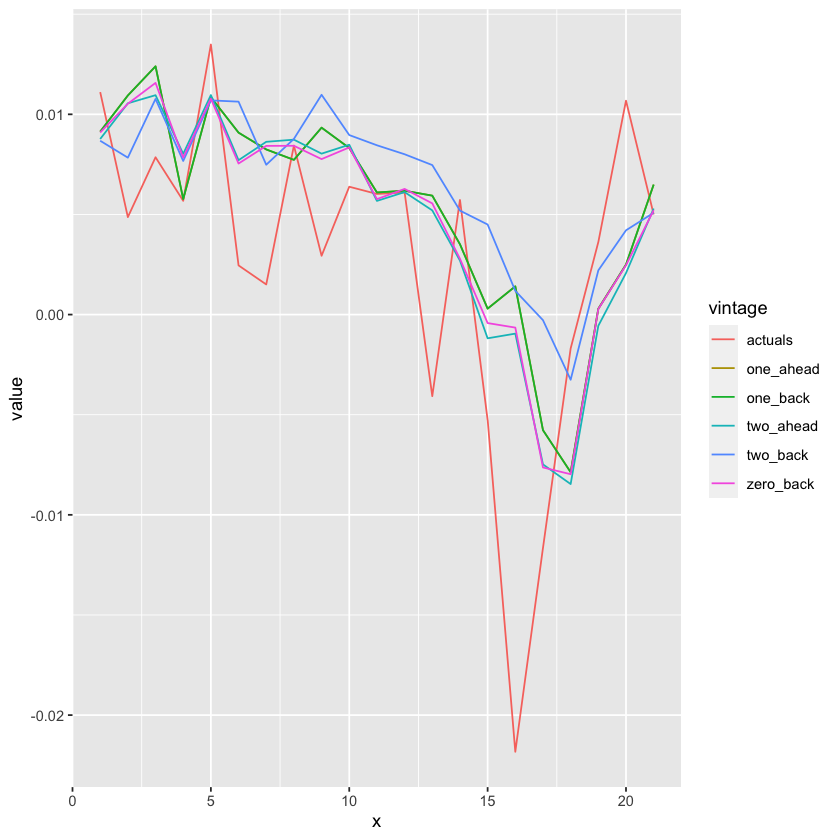

In [10]:
# plot of predictions vs actuals
p <- tibble(
    actuals = actuals,
    two_back = pred_dict[, "-2"], 
    one_back = pred_dict[, "-1"], 
    zero_back = pred_dict[, "0"],
    one_ahead = pred_dict[, "-1"],
    two_ahead = pred_dict[, "2"]
) %>%
    mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x=x, y=value, color=vintage) + 
    geom_line()
p

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [12]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data <- test
output_dfm <- dfm(data = new_data, blocks = blocks, max_iter=500)

predict_dfm(new_data, output_dfm) %>%
    dplyr::filter(date == "2010-06-01") %>%
    select(!!target_variable) %>%
    pull()

[1] 0.01011395